In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

(37500, 32, 32, 3) (37500, 10) (12500, 32, 32, 3) (12500, 10) (10000, 32, 32, 3) (10000, 10)


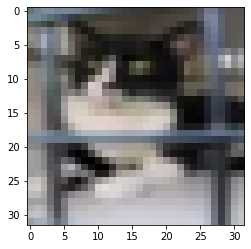

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] cat


In [2]:
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (x_test, y_test) = cifar10.load_data()


train_images = train_images.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
train_labels = to_categorical(train_labels, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images,train_labels,random_state=123)

print(x_train.shape,
      y_train.shape,
      x_val.shape,
      y_val.shape,
      x_test.shape,
      y_test.shape)

def labeling_vec(t):
    label_list = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    ll = np.arange(10)
    l = np.dot(t,ll)
    return label_list[int(l)]

k = 9
plt.imshow(x_train[k])
plt.show()
print(y_train[k],labeling_vec(y_train[k]))

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import models
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input

# 使うGPU番号を指定(私の場合は9番を使用)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。（命苫メソッド）
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from keras.callbacks import LearningRateScheduler

EPOCHS = 150
# 学習率
def step_decay(epoch):
    x = 0.0001
    warmup = 5
    if epoch < warmup:
        x *= (epoch+1)/warmup
    else:
        x *= (1 + np.cos(np.pi*(epoch+1-warmup)/EPOCHS))/2
    return x


#defining layers

def basic_conv_block(input, chs, sh, reps): ##sh畳み込み大きさ, reps回数
    x = input
    for i in range(reps):
        x = layers.Conv2D(chs,(sh,sh),padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
    return x

#Squeezeblock
#https://arxiv.org/abs/1709.01507def SEblock(input,chs): 
    z = layers.Conv2D(chs,(1,1),padding="same", kernel_initializer='he_normal')(input)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(chs//16, activation='relu')(z)
    z = layers.Dense(chs, activation='sigmoid')(z)
    z = layers.Reshape((1, 1, chs))(z)
    x = layers.Multiply()([input, z])
    return x

#residualとSEブロックを組み合わせたconv block
def residual_SE_conv_block(input, chs, sh, reps): ##sh畳み込み大きさ, reps回数
    x = input
    residual = layers.Conv2D(chs,(1,1),padding="same", kernel_initializer='he_normal')(input)
    for i in range(reps):
        x = layers.Conv2D(chs,(sh,sh),padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
    x = layers.Add()([x,residual])
    x = SEblock(x,chs)
    return x

#creating the model

def create_cnn(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = basic_conv_block(input, 64, 5, 1)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 128, 3, 3)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 256, 3, 3)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax')(x)

    model = Model(input, x)
    return model

def create_residual_cnn(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = residual_SE_conv_block(input, 64, 5, 1)
    x = layers.AveragePooling2D(2)(x)
    x = residual_SE_conv_block(x, 128, 3, 3)
    x = layers.AveragePooling2D(2)(x)
    x = residual_SE_conv_block(x, 256, 3, 3)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax')(x)

    model = Model(input, x)
    return model


from tensorflow.keras.callbacks import History, Callback
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import os, pickle
import tensorflow.keras.backend as K

# 確率の平均を取るアンサンブル（ソフトアンサンブル）
def ensembling_soft(models, X):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)
        else:
            preds_sum += model.predict(X)
    probs = preds_sum / len(models)
    return to_categorical(np.argmax(probs, axis=1), num_classes=10)

# 多数決のアンサンブル（ハードアンサンブル）
def ensembling_hard(models, X):
    pred_labels = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        pred_labels[:, i] = np.argmax(model.predict(X), axis=1)
    return to_categorical(mode(pred_labels, axis=1)[0], num_classes=10)

class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0

    def on_epoch_end(self, epoch, logs):
        if self.best_val_acc < logs["val_acc"]:
            self.model.save_weights(self.filepath, save_format="h5")
            self.best_val_acc = logs["val_acc"]
            print("Weights saved.", self.best_val_acc)

Using TensorFlow backend.


In [5]:
vers = 1
SHAPE=32
channel=3
teacher_model = create_cnn(SHAPE,channel)
teacher_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512   

In [6]:
teacher_model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['acc'])

EPOCHS = 30
csv_logger = CSVLogger('distill_trlog_{}'.format(vers), separator=',', append=False)

early_stopping = EarlyStopping(monitor="val_acc", patience=8)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
learning_rate = LearningRateScheduler(step_decay,verbose=1)
cp = Checkpoint(teacher_model, f"weights{vers}.hdf5")

history = teacher_model.fit(x=x_train,
                    y=y_train,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=50,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=[cp,
                                early_stopping,
                               csv_logger,
                                learning_rate
                              ]
                    )

Train on 37500 samples, validate on 12500 samples

Epoch 00001: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
37500/37500 [==============================] - 18s 493us/sample - loss: 1.5740 - acc: 0.4267 - val_loss: 0.1819 - val_acc: 0.4919

Epoch 00002: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/30
37500/37500 [==============================] - 11s 302us/sample - loss: 1.2214 - acc: 0.5630 - val_loss: 0.1561 - val_acc: 0.5731

Epoch 00003: LearningRateScheduler setting learning rate to 6e-05.
Epoch 3/30
37500/37500 [==============================] - 11s 303us/sample - loss: 1.0426 - acc: 0.6331 - val_loss: 0.1374 - val_acc: 0.6250

Epoch 00004: LearningRateScheduler setting learning rate to 8e-05.
Epoch 4/30
37500/37500 [==============================] - 11s 300us/sample - loss: 0.9034 - acc: 0.6829 - val_loss: 0.1462 - val_acc: 0.6012

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/30
37500/37500 [=====================

version: 1 best val score 0.81625


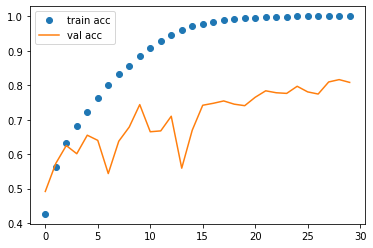

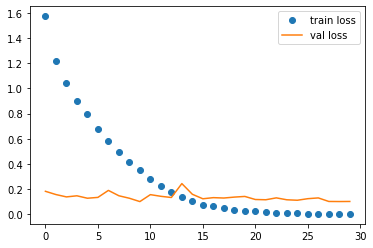

In [7]:
log_data = pd.read_csv('distill_trlog_{}'.format(vers), sep=',', engine='python')
print('version:',vers,'best val score',np.max(log_data.val_acc))

plt.plot(log_data.index,log_data.acc,'o',label='train acc')
plt.plot(log_data.index,log_data.val_acc,label='val acc')
plt.legend()
plt.show()
plt.plot(log_data.index,log_data.loss,'o',label='train loss')
plt.plot(log_data.index,log_data.val_loss,label='val loss')
plt.legend()
plt.show()

In [9]:
teacher_model.evaluate(x_test, y_test) #loss/acc

10000/10000 [==============================] - 1s 148us/sample - loss: 0.7263 - acc: 0.8250


[0.726259511756897, 0.825]

In [10]:
model = Sequential()
for layer in teacher_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
for layer in model.layers:
    layer.trainable = False
teacher = model
teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0

In [32]:
def create_cnn_st(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = basic_conv_block(input, 64, 5, 1)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 128, 3, 2)  ##repsを3から2に
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 256, 3, 2)  ##repsを3から2に
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation("softmax")(x)

    model = Model(input, x)
    return model


vers = 4

student = create_cnn_st(SHAPE,channel)
student.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 16, 128)       512 

In [13]:
#普通に学習

student.compile(optimizer=optimizers.Adam(lr=1e-4), loss='categorical_crossentropy',metrics=['acc'])

EPOCHS = 30
csv_logger = CSVLogger('distill_trlog_{}'.format(vers), separator=',', append=False)

early_stopping = EarlyStopping(monitor="val_acc", patience=8)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
learning_rate = LearningRateScheduler(step_decay,verbose=1)
cp = Checkpoint(student, f"weights{vers}.hdf5")

history = student.fit(x=x_train,
                    y=y_train,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=50,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=[cp,
                                early_stopping,
                               csv_logger,
                                learning_rate
                              ]
                    )

Train on 37500 samples, validate on 12500 samples

Epoch 00001: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
37500/37500 [==============================] - 11s 292us/sample - loss: 6.9494 - acc: 0.1170 - val_loss: 0.9709 - val_acc: 0.1713

Epoch 00002: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/30
37500/37500 [==============================] - 10s 266us/sample - loss: 6.0023 - acc: 0.1558 - val_loss: 0.5843 - val_acc: 0.1231

Epoch 00003: LearningRateScheduler setting learning rate to 6e-05.
Epoch 3/30
37500/37500 [==============================] - 10s 265us/sample - loss: 3.8283 - acc: 0.0793 - val_loss: 0.4164 - val_acc: 0.0650

Epoch 00004: LearningRateScheduler setting learning rate to 8e-05.
Epoch 4/30
37500/37500 [==============================] - 10s 264us/sample - loss: 2.9575 - acc: 0.0748 - val_loss: 0.3656 - val_acc: 0.0781

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/30
37500/37500 [=====================

version: 4 best val score 0.17125


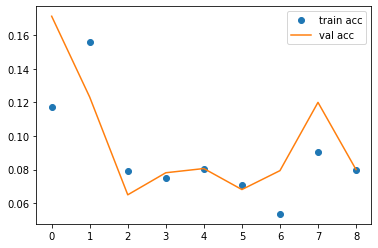

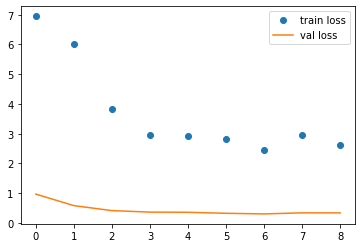

In [14]:
log_data = pd.read_csv('distill_trlog_{}'.format(vers), sep=',', engine='python')
print('version:',vers,'best val score',np.max(log_data.val_acc))

plt.plot(log_data.index,log_data.acc,'o',label='train acc')
plt.plot(log_data.index,log_data.val_acc,label='val acc')
plt.legend()
plt.show()
plt.plot(log_data.index,log_data.loss,'o',label='train loss')
plt.plot(log_data.index,log_data.val_loss,label='val loss')
plt.legend()
plt.show()

In [15]:
student.evaluate(x_test, y_test) #loss/acc

10000/10000 [==============================] - 1s 112us/sample - loss: 2.7098 - acc: 0.0899


[2.7098274520874024, 0.0899]

In [33]:
student = create_cnn_st(SHAPE,channel)

model = Sequential()
for layer in student.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
#for layer in model.layers:
    #layer.trainable = False
student = model
student.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
activation_42 (Activation)   (None, 16, 16, 128)      

In [34]:
#教授コード参考
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

model_input = Input(shape=(32,32,3))

student_logid = student(model_input)
teacher_logid = teacher(model_input)

student_softmax = layers.Activation('softmax')(student_logid)

logids = Concatenate(axis=-1)([student_logid, teacher_logid])

model = Model(inputs=model_input, outputs=[student_softmax, logids])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 10)           1117450     input_10[0][0]                   
__________________________________________________________________________________________________
model (Model)                   (None, 10)           1856650     input_10[0][0]                   
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 10)           0           sequential_4[1][0]               
____________________________________________________________________________________________

In [35]:
import tensorflow.keras.backend as K
import tensorflow as tf

temperature = 20.

def distillation_loss_kldivergence(y_true, y_pred):
    student_logid, teacher_logid = tf.split(y_pred, 2, axis=-1)
  
    student_soft = K.softmax(student_logid/temperature)
    teacher_soft = K.softmax(teacher_logid/temperature)

    #return K.categorical_crossentropy(teacher_soft, student_soft)
    return tf.keras.losses.kullback_leibler_divergence(teacher_soft,student_soft)

#教授コード参考
def distillation_loss_crossentropy(y_true, y_pred):
    student_logid, teacher_logid = tf.split(y_pred, 2, axis=-1)
  
    student_soft = K.softmax(student_logid/temperature)
    teacher_soft = K.softmax(teacher_logid/temperature)

    return K.categorical_crossentropy(teacher_soft, student_soft)
#     return tf.keras.losses.kullback_leibler_divergence(teacher_soft,student_soft)

In [36]:
#教授コード参考
from tensorflow.keras import optimizers

lambda_const = 0.9
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


model.compile(loss = ["categorical_crossentropy",distillation_loss_kldivergence], loss_weights=[1-lambda_const, lambda_const * temperature**2], optimizer = adam)
#model.compile(loss = ["categorical_crossentropy",distillation_loss_crossentropy], loss_weights=[1-lambda_const, lambda_const * temperature**2], optimizer = adam)

In [37]:
EPOCHS = 30
csv_logger = CSVLogger('distill_trlog_{}'.format(vers), separator=',', append=False)

early_stopping = EarlyStopping(monitor="val_acc", patience=8)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
learning_rate = LearningRateScheduler(step_decay,verbose=1)
cp = Checkpoint(model, f"weights{vers}.hdf5")

history = model.fit(x=x_train,
                    y=[y_train,y_train],
                    epochs=EPOCHS,
                    #validation_data=(x_val,y_val),
                    #validation_steps=50,
                    #use_multiprocessing=True,
                    #workers=4,
                    #callbacks=[cp,
                                #early_stopping,
                               #csv_logger,
                                #learning_rate]
                    )

Train on 37500 samples
Epoch 1/30
37500/37500 [==============================] - 14s 372us/sample - loss: 0.2523 - activation_47_loss: 2.0615 - concatenate_1_loss: 1.2808e-04
Epoch 2/30
37500/37500 [==============================] - 13s 343us/sample - loss: 0.2236 - activation_47_loss: 1.8483 - concatenate_1_loss: 1.0776e-04
Epoch 3/30
37500/37500 [==============================] - 16s 434us/sample - loss: 0.2056 - activation_47_loss: 1.7019 - concatenate_1_loss: 9.8466e-05
Epoch 4/30
37500/37500 [==============================] - 13s 336us/sample - loss: 0.1931 - activation_47_loss: 1.5970 - concatenate_1_loss: 9.2853e-05
Epoch 5/30
37500/37500 [==============================] - 13s 336us/sample - loss: 0.1826 - activation_47_loss: 1.5090 - concatenate_1_loss: 8.8103e-05
Epoch 6/30
37500/37500 [==============================] - 13s 339us/sample - loss: 0.1751 - activation_47_loss: 1.4454 - concatenate_1_loss: 8.4776e-05
Epoch 7/30
37500/37500 [==============================] - 13s 343

In [38]:
full_input = Input(shape=(32,32,3))
full_logid = student(full_input)
full_output = layers.Activation('softmax')(full_logid)

full_student = Model(inputs=full_input, outputs=full_output)

full_student.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
full_student.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)                1117450   
_________________________________________________________________
activation_48 (Activation)   (None, 10)                0         
Total params: 1,117,450
Trainable params: 1,115,786
Non-trainable params: 1,664
_________________________________________________________________


In [39]:
full_student.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 138us/sample - loss: 1.3389 - accuracy: 0.8310


[1.33887417678833, 0.831]

In [40]:
teacher_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 151us/sample - loss: 0.7263 - acc: 0.8250


[0.726259511756897, 0.825]